**Update**: Thanks to MingGu and Jianfa for testing only use "Plus" features which also gives you 0.922. 

In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import gc
import time
plt.style.use('seaborn')
sns.set(font_scale=1)
from tqdm import tnrange, tqdm, tqdm_notebook

In [2]:
train = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
fake_ids = np.load('../input/fakeids/synthetic_samples_indexes.npy')
ids = np.arange(test.shape[0])
real_ids = list(set(ids) - set(fake_ids))
real_test = test.iloc[real_ids]
fake_test = test.iloc[fake_ids]
real_test_id = real_test.ID_code

In [3]:
features = [c for c in train.columns if c not in ['target', 'ID_code']]

In [4]:
df = pd.concat([train,real_test], axis = 0)
for feat in tqdm_notebook(features):
    df[feat+'_var'] = df.groupby([feat])[feat].transform('var')
for feat in tqdm_notebook(features):
    df[feat+'plus_'] = df[feat] + df[feat+'_var']
    # df[feat+'minus_'] = df[feat] - df[feat+'_var'] this is not necessary
drop_features = [c for c in df.columns if '_var' in c]
df.drop(drop_features, axis=1, inplace=True)

In [5]:
train = df.iloc[:train.shape[0]]
real_test = df.iloc[train.shape[0]:]

In [6]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target'] 

In [7]:
print(train.shape)
print(real_test.shape)
print(len(features))

(200000, 402)
(100000, 402)
400


In [8]:
param = {
    'bagging_freq': 5,  'bagging_fraction': 0.4,  'boost_from_average':'false',   
    'boost': 'gbdt',    'feature_fraction': 0.04, 'learning_rate': 0.01,
    'max_depth': -1,    'metric':'auc',             'min_data_in_leaf': 80,
    'num_leaves': 13,  'num_threads': 8,            
    'tree_learner': 'serial',   'objective': 'binary',       'verbosity': 1
}

In [9]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4242)
oof = np.zeros(len(train))
predictions = np.zeros(len(real_test))
val_aucs = []
feature_importance_df = pd.DataFrame()

In [10]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 100000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    val_aucs.append(roc_auc_score(target[val_idx] , oof[val_idx] ))
    predictions += clf.predict(real_test[features], num_iteration=clf.best_iteration) / folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


Fold 0
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.950123	valid_1's auc: 0.923615
[10000]	training's auc: 0.969304	valid_1's auc: 0.925306
Early stopping, best iteration is:
[10378]	training's auc: 0.970494	valid_1's auc: 0.925351
Fold 1
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.950365	valid_1's auc: 0.922149
[10000]	training's auc: 0.969357	valid_1's auc: 0.92344
Early stopping, best iteration is:
[9675]	training's auc: 0.968331	valid_1's auc: 0.923495
Fold 2
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.950794	valid_1's auc: 0.918831
[10000]	training's auc: 0.969927	valid_1's auc: 0.921176
Early stopping, best iteration is:
[11721]	training's auc: 0.974996	valid_1's auc: 0.921298
Fold 3
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.950672	valid_1's auc: 0.920921
[10000]	training's auc: 0.969555	valid_1's auc:

In [11]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(target, oof)
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))


Mean auc: 0.922588820, std: 0.001915897. All auc: 0.922458644.


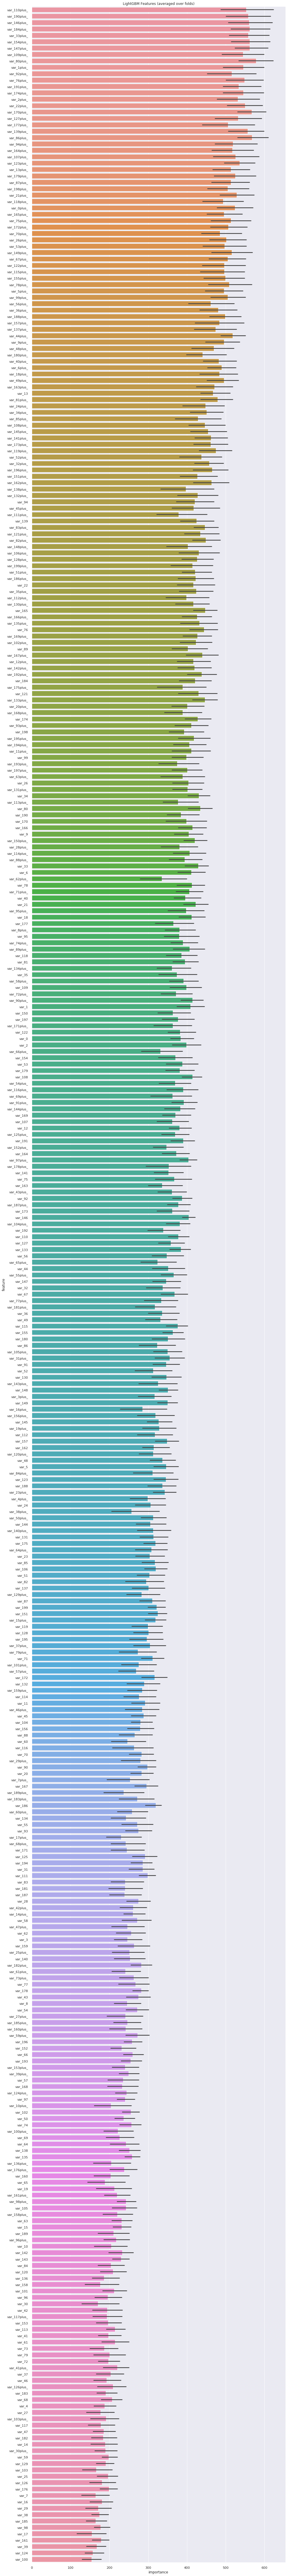

In [12]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,124))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [13]:
subreal = pd.DataFrame({"ID_code": real_test_id.values})
subreal['target']=predictions
sub = pd.DataFrame({"ID_code": test.ID_code.values})

In [14]:
finalsub = sub.set_index('ID_code').join(subreal.set_index('ID_code')).reset_index()
finalsub.fillna(0,inplace=True)
finalsub.to_csv("submission.csv", index=False)

In [15]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission.csv')